In [88]:
#importing relevant modules
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pandas as pd
from matplotlib.animation import FFMpegWriter
from mpl_toolkits.basemap import Basemap
import os
import requests
import dateutil.parser
from datetime import timedelta, datetime
from obspy import UTCDateTime

In [80]:
firstquakeid = "2014p051675" # user input Geonet public ID 

In [81]:
quake = requests.get("https://api.geonet.org.nz/quake/2014p051675").json()
starttime = dateutil.parser.isoparse(quake['features'][0]['properties']['time'])
endtime = starttime + timedelta(days = 1)
start, end = starttime.strftime('%Y-%m-%dT%H:%M:%S'), endtime.strftime('%Y-%m-%dT%H:%M:%S')
lon, lat = quake['features'][0]['geometry']['coordinates'][0], quake['features'][0]['geometry']['coordinates'][1]
latlon = str(lon) + "+" + str(lat)

In [82]:
quakejson = requests.get(
        "http://wfs.geonet.org.nz/geonet/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=geonet:quake_search_v1&outputFormat=json&cql_filter=origintime>=" 
        + start + "+AND+origintime<=" + end + "+AND+DWITHIN(origin_geom,Point+(" + latlon + "),50000,meters)").json()

In [101]:
quakejson['features'][0]
lat, lon, mag, time = ([] for i in range(4))
for a in range(len(quakejson['features'])):
    lon.append(quakejson['features'][a]['geometry']['coordinates'][0])
    lat.append(quakejson['features'][a]['geometry']['coordinates'][1])
    mag.append(quakejson['features'][a]['properties']['magnitude'])
    time.append(UTCDateTime(quakejson['features'][a]['properties']['origintime']))
df = pd.DataFrame({"lat":lat, "lon":lon, "time":time,"mag":mag})
df = df.sort_values(by = "time")
df.head()

,lat,lon,time,mag
438,-40.620579,175.86497,2014-01-20T02:52:45.984000Z,6.229762
437,-40.692373,175.81968,2014-01-20T02:56:31.866000Z,4.018754
436,-40.656733,175.81951,2014-01-20T02:58:00.347000Z,4.215670
435,-40.664632,175.83982,2014-01-20T02:59:19.750000Z,3.379092
434,-40.699915,175.82104,2014-01-20T02:59:53.645000Z,3.113108


/opt/conda/envs/gha/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until


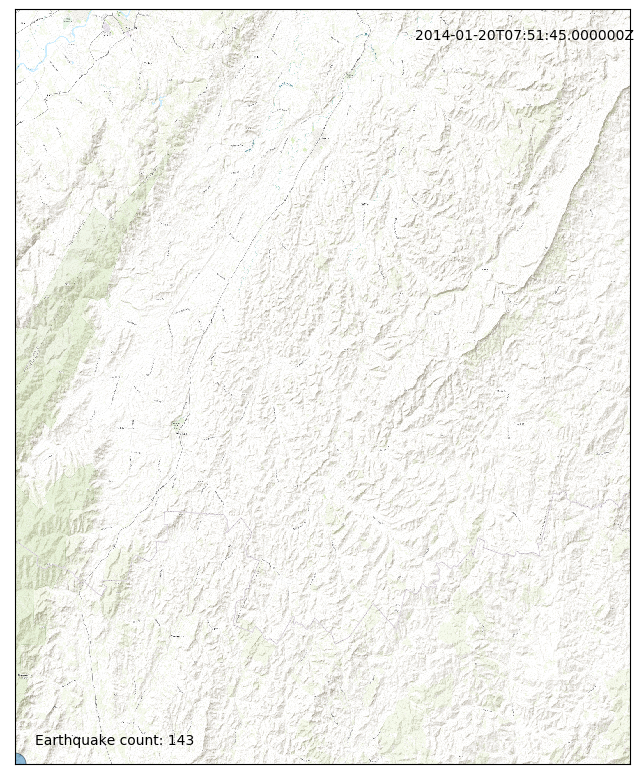

In [108]:
fig, ax = plt.subplots(figsize = (15, 10), dpi = 100)
m = Basemap(projection = "merc", llcrnrlon = lon[0] - .25, llcrnrlat =  lat[0] - .25,
              urcrnrlon =  lon[0] + .25, urcrnrlat = lat[0] + .25, epsg = 2193)
m.arcgisimage(service = "World_Topo_Map", xpixels = 1500, ypixels = 1500)
timelist = [list(df['time'])[0] + 60 * x for x in range(300)]
stime = [str(UTCDateTime(start)+ 60 * i) for i in list(range(len(timelist)))]
roundmag = [(int(str(x)[0])+1)**4 * 2 for x in mag]
scat= m.scatter([],[], alpha = 0.5, edgecolor= "black", linewidths = 0.6)  
annotation = ax.annotate(str(stime[0]), xy=(400, 725), xycoords='axes pixels',  fontsize=10)
annotationcount = ax.annotate("Earthquake count: 0", xy = (20, 20), xycoords='axes pixels', fontsize = 10)
annotation.set_animated(True)
annotationcount.set_animated(True)
def init():
    scat.set_offsets(np.c_[0,0])
    return scat, annotation, annotationcount
def update(a):
    df2 = df[df['time'] < timelist[a]]
    x, y = m(list(df2['lon']), list(df2['lat']))
    scat.set_offsets(np.c_[x, y])
    scat._sizes=[(int(str(x)[0])+1)**2.5 * 2 for x in list(df2['mag'])]
    annotation.set_text(stime[a])
    annotationcount.set_text("Earthquake count: " + str(len(df2)))
    return scat,
ani = animation.FuncAnimation(fig, update, init_func=init, interval = 10, blit=False, frames = len(timelist))
writer = FFMpegWriter(fps=5, bitrate=1800)
ani.save(("banana.mp4"), writer=writer)

2014-01-20T02:52:45.984000Z